In [1]:
# !pip install stellargraph[demos]
# !pip install tf-nightly

In [1]:
import stellargraph as sg
import os
import sys
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from stellargraph.layer import GCN_LSTM

import datetime
import random
random.seed(45)
tf.random.set_seed(10)

2022-04-21 16:29:03.832583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 16:29:03.832679: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-21 16:29:43.174621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 16:29:43.175614: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 16:29:43.175842: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-F3GKG0K): /proc/driver/nvidia/version does not exist
2022-04-21 16:29:43.182546: I tensorflow/core/platform/cpu_fe

In [2]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [3]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25

#adjacency matrix
grid_points = pd.read_csv('grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [4]:
def data_preparation(datafile1):
    #Put the file location
    df = pd.read_csv(datafile1)
    
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    # TODO: Add buffer and consider train-data for range
    # lat_range = {'min': df.lat.min(), 'max': df.lat.max()}
    # long_range = {'min': df.long.min(), 'max': df.long.max()}
    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)
    means = df[["lat_grid", "long_grid", "pm2_5"]].groupby(['lat_grid', 'long_grid']).mean().reset_index()['pm2_5'].values

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute

    # only PM2_5
    df = df[['dateTime','lat_grid','long_grid','pm2_5']]
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
#     df = df.fillna(method='ffill')
#     df = df.fillna(method='bfill')
#     df = df.interpolate(limit_direction="both")
#     df = df.interpolate(method='spline', order=3)
#     df = df.fillna(0)
    columns = df.columns
    df = df[columns[2:]]
    df = df.fillna(0)
#     df['means'] = means
    return df

# Fill missing values

In [5]:
# !pip install missingno

In [5]:
# import missingno as msno
# import matplotlib.pyplot as plta
df = data_preparation('PM Datasets/2021-01-23_all.csv')
# # msno.bar(df, figsize=(12, 6), fontsize=12, color='steelblue')
# msno.bar(df, color='steelblue')

In [6]:
df

dateTime                  360         540         720         900   \
lat_grid long_grid                                                   
0        21         146.000000    0.000000    0.000000    0.000000   
         22         153.707891  160.562637  129.051144  101.154985   
1        19         118.645833  132.193548  160.869565  139.480000   
         20         123.754545  133.450980  151.697674  127.581818   
         21         137.436735  145.091575  136.130435  112.536458   
...                        ...         ...         ...         ...   
18       23         104.777778  142.714286   98.105263   78.568182   
         24         102.646154  165.800000  119.405405   85.841121   
19       14         157.407407  172.000000  146.230769    0.000000   
         19           0.000000  189.280000  174.516129    0.000000   
         20           0.000000  179.382166  145.768473    0.000000   

dateTime                  1080        1260  
lat_grid long_grid                          
0        21           0.000000    0.000000  
         22         161.138867  207.135676  
1        19           0.000000  304.500000  
         20           0.000000  266.000000  
         21         188.607143  238.790000  
...                        ...         ...  
18       23           0.000000  149.281250  
         24           0.000000  139.301471  
19       14           0.000000    0.000000  
         19         156.033333  264.225806  
         20         182.930348  289.290155  

[154 rows x 6 columns]

In [7]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# df = data_preparation('PM Datasets/2021-01-23_all.csv')
# imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=5)
# imputed_dataset = imputer.fit_transform(df)

In [8]:
def my_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
#     mask = tf.sign(y_true)
#     print(mask[mask>0])
#     y_pred = y_pred*(mask)
    loss = mse(y_pred[y_true>0], y_true[y_true>0] )
#     loss = mse(tf.reshape(y_true,(-1,)),tf.reshape(y_pred,(-1,)))
    return loss

In [9]:
def train_model(trainX, trainY, testX, testY, train_data, n_epochs):
    cb = TimingCallback()
    
    history = model.fit(
            trainX,
            trainY,
            epochs = n_epochs,
            batch_size = 1,
            shuffle=True,
            verbose=0,
            validation_data=[testX, testY],
            callbacks=[cb]
        ) 

    print(
        "Mean Train loss: ",
        sum(tf.sqrt(history.history["loss"]))*max_pm/len(history.history["loss"]),
        "\n Last Train loss: ",
        tf.sqrt(history.history["loss"][-1])*max_pm,
        "\n Mean Test loss:",
        sum(tf.sqrt(history.history["val_loss"]))*max_pm/len(history.history["val_loss"]),
        "\n Last Test loss:",
        tf.sqrt(history.history["val_loss"][-1])*max_pm,
    #     "\nTrain time ", traintime,
        "\n Train time callbacks", sum(cb.logs)
        
    )
    sg.utils.plot_history(history)

In [10]:
def eval(model, testX, testY):
    output = model.predict(trainX)
    # yhat = model.predict(testX)

    ## actual train and test values
    ## Rescale values
    train_true = np.array((trainY * (max_pm - min_pm)) + min_pm)
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)

    ## Rescale model predicted values
    train_output = np.array((output * (max_pm - min_pm)) + min_pm)
    # test_rescpred = np.array((yhat * (max_pm - min_pm)) + min_pm)

    # # Masked predicted values
    # mask_train = tf.sign(trainY)
    mask_test = tf.sign(testY)
    # train_rescpred = train_rescpred*(mask_train)
    test_output = train_output*(mask_test)
    test_mse = my_loss(test_true, train_output)
    test_rmse = tf.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return test_output, test_true

In [11]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 4

#adjacency matrix
grid_points = pd.read_csv('grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [12]:
gcn_lstm = GCN_LSTM(
        seq_len=seq_len,
        adj=adj,
        gc_layer_sizes=[4, 4],
        gc_activations=["relu", "relu"],
        lstm_layer_sizes=[4],
        lstm_activations=["tanh"]
    )
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
opt = tf.optimizers.Adam(learning_rate = 0.003)
model.compile(optimizer=opt, loss=my_loss)
# model.compile(optimizer=opt, loss="mae")
print(model.summary())

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:7: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  import sys


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 270, 4)]          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 270, 4, 1)        0         
                                                                 
 reshape (Reshape)           (None, 270, 4)            0         
                                                                 
 fixed_adjacency_graph_convo  (None, 270, 4)           73186     
 lution (FixedAdjacencyGraph                                     
 Convolution)                                                    
                                                                 
 fixed_adjacency_graph_convo  (None, 270, 4)           73186     
 lution_1 (FixedAdjacencyGra                                     
 phConvolution)                                              

In [46]:
# df = data_preparation('PM Datasets/2021-01-23_all.csv')
# trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_portion = 0.8, known_portion = 0.8)
# max_pm = train_data.max()
# min_pm = train_data.min()
# train_model(trainX, trainY, testX, testY, train_data, n_epochs = 100)

In [67]:
df = data_preparation('PM Datasets/2020-12-01_all.csv')
# train_data, train_known_data, test_data, test_known_data = train_test_split(df, grid_points_indices, train_portion = 0.8, known_portion = 0.8)

for i in range(2, 8):
    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)

In [68]:
df = df.fillna(0)

In [69]:
df

dateTime                  360         540         720         900   \
lat_grid long_grid                                                   
0        22         274.869242  275.605369  185.320702  142.292380   
1        19           0.000000    0.000000    0.000000    0.000000   
         20           0.000000    0.000000    0.000000    0.000000   
         21         277.657143  290.829787  191.355140  133.500000   
         22         274.326007  286.357724  210.973510  143.156716   
...                        ...         ...         ...         ...   
22       9            0.000000    0.000000    0.000000    0.000000   
         10           0.000000    0.000000    0.000000    0.000000   
         13           0.000000    0.000000    0.000000    0.000000   
23       13           0.000000    0.000000    0.000000    0.000000   
24       13           0.000000    0.000000    0.000000    0.000000   

dateTime                  1080        1260        360         540   \
lat_grid long_grid                                                   
0        22         210.565693  303.773973  294.314286  264.939597   
1        19           0.000000    0.000000    0.000000    0.000000   
         20           0.000000    0.000000    0.000000    0.000000   
         21         184.521739  309.384615    0.000000    0.000000   
         22         195.157143  279.916667  272.777778  304.150000   
...                        ...         ...         ...         ...   
22       9            0.000000    0.000000    0.000000    0.000000   
         10           0.000000    0.000000    0.000000    0.000000   
         13           0.000000    0.000000    0.000000    0.000000   
23       13           0.000000    0.000000    0.000000    0.000000   
24       13           0.000000    0.000000    0.000000    0.000000   

dateTime                  720         900   ...        720         900   \
lat_grid long_grid                          ...                           
0        22         162.608789  121.168889  ...  231.390612  135.796733   
1        19           0.000000    0.000000  ...    0.000000    0.000000   
         20           0.000000    0.000000  ...    0.000000    0.000000   
         21         151.833333  123.111111  ...  233.914634  102.900000   
         22         160.982249  116.900000  ...  247.453287   93.690768   
...                        ...         ...  ...         ...         ...   
22       9            0.000000    0.000000  ...    0.000000    0.000000   
         10           0.000000    0.000000  ...    0.000000    0.000000   
         13         257.000000    0.000000  ...    0.000000    0.000000   
23       13         251.472727    0.000000  ...    0.000000    0.000000   
24       13         254.466667    0.000000  ...    0.000000    0.000000   

dateTime                  1080        1260        360         540   \
lat_grid long_grid                                                   
0        22         214.646186  244.475482  334.385452  295.656468   
1        19           0.000000    0.000000    0.000000    0.000000   
         20           0.000000    0.000000    0.000000    0.000000   
         21         212.177419  284.512821  345.227273  312.906977   
         22         130.320513  267.600000  353.393130  296.846154   
...                        ...         ...         ...         ...   
22       9            0.000000    0.000000    0.000000    0.000000   
         10           0.000000    0.000000    0.000000    0.000000   
         13           0.000000    0.000000    0.000000    0.000000   
23       13           0.000000    0.000000    0.000000    0.000000   
24       13           0.000000    0.000000    0.000000    0.000000   

dateTime                  720         900         1080        1260  
lat_grid long_grid                                                  
0        22         198.412661  167.570285  235.576463  270.918558  
1        19           0.000000    0.000000    0.000000    0.000000  
         20    

In [70]:
seq_len = 4
train_portion = 0.8
known_portion = 0.8
time_len = df.shape[1]
points_len = df.shape[0]
train_size = int(time_len * train_portion) 
# train_size = time_len - seq_len
known_size = int(points_len * known_portion)
unknown_size = points_len - known_size

#train-test split
train_data = df.iloc[:, :train_size]
test_data = df.iloc[:, train_size:]

#rescale
max_pm = train_data.to_numpy().max()
min_pm = train_data.to_numpy().min()
train_data = (train_data - min_pm) / (max_pm - min_pm)
test_data = (test_data - min_pm) / (max_pm - min_pm)
# known, unknown split in each batch
trainX, trainY, testX, testY = [], [], [], []
for i in range(train_data.shape[1] - int(seq_len - 1)):
    train_data_batch = train_data.iloc[:, i : i + seq_len]
#     train_data_batch = train_data_batch.loc[(train_data_batch != 0).any(axis=1)]
#     train_known_data_batch = train_data_batch.mask(np.random.random(train_data_batch.shape) < 0.2).fillna(0)
    train_unknown_indices = random.sample(list(train_data_batch.index), unknown_size)
    train_known_indices = set(train_data_batch.index) - set(train_unknown_indices)
    train_known_data_batch = train_data_batch.loc[train_known_indices, :] 
    trainX.append(train_known_data_batch.reindex(grid_points_indices,fill_value=0))
    trainY.append(train_data_batch.reindex(grid_points_indices,fill_value=0))
    
for i in range(test_data.shape[1] - int(seq_len - 1)):
    test_data_batch = test_data.iloc[:, i : i + seq_len]
#     test_data_batch = test_data_batch.loc[(test_data_batch != 0).any(axis=1)]
#     test_known_data_batch = test_data_batch.mask(np.random.random(test_data_batch.shape) < 0.2).fillna(0)
    test_unknown_indices = random.sample(list(test_data_batch.index), unknown_size)
    test_known_indices = set(test_data_batch.index) - set(test_unknown_indices)
    test_known_data_batch = test_data_batch.loc[test_known_indices, :]  
    testX.append(test_known_data_batch.reindex(grid_points_indices,fill_value=0))
    testY.append(test_data_batch.reindex(grid_points_indices,fill_value=0))
    
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
#     return trainX, trainY, testX, testY

(30, 270, 4)
(30, 270, 4)
(6, 270, 4)
(6, 270, 4)


Mean Train loss:  tf.Tensor(57.236835, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(48.475365, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(68.58678, shape=(), dtype=float32) 
 Last Test loss: tf.Tensor(66.58886, shape=(), dtype=float32) 
 Train time callbacks 11.797958200026187


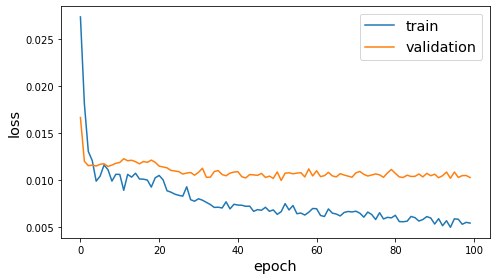

In [101]:
train_model(trainX, trainY, testX, testY, train_data, n_epochs = 100)

In [ ]:
# n_epochs = 100
# train_loss_array = []
# train_rmse_array = []
# test_loss_array = []
# test_rmse_array = []
# x = trainX
# y = trainY
# x_val = testX
# y_val = testY
# for epoch in range(n_epochs):
    
#     with tf.GradientTape() as tape: # Forward pass
#         y_ = model(x, training=True)
#         loss = my_loss(y_true=y, y_pred=y_)
#     grad = tape.gradient(loss, model.trainable_variables) # Backpropagation
#     opt.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
#     train_loss_array.append(loss)
#     train_rmse_array.append(tf.sqrt(loss))
# #     print(loss)
    
#     y_test = model.predict(x_val) # Validation predictions
#     test_loss = my_loss(y_true=y_val, y_pred=y_test)
#     test_loss_array.append(test_loss)
#     test_rmse_array.append(tf.sqrt(test_loss))
# #     print(test_loss)

In [ ]:
# import matplotlib.pyplot as plt
# titleFontSize = 15
# labelFontSize = 12
# tickFontSize = 10
# legendFontSize = 10
# labelStr = "size = "
# yLabel = "% of test points with lower error"
# xLabel = "Error %"
# count_arr = [i for i in range(1, len(train_loss_array) + 1)]
# plt.plot(count_arr, train_loss_array, label = "Train loss", color='red')
# plt.plot(count_arr, test_loss_array, label = "Test loss", color='blue')
# plt.title("Training loss vs epochs(Pytorch)", fontsize=titleFontSize)
# plt.xlabel("Epochs", fontsize=labelFontSize)
# plt.ylabel("Training loss", fontsize=labelFontSize)
# plt.xticks(fontsize=tickFontSize)
# plt.yticks(fontsize=tickFontSize)
# plt.tight_layout()
# plt.legend(prop={"size": legendFontSize})
# # plt.savefig("pytorch_loss.png")